# Sentiment prediction

Notebook that loads the spanish sentiment model and makes the predictions on new data.

The data is taken from a whatsapp group chat exported in txt. If you are going to use this notebook, check if the preprocessing of the messages is good because the format depends on the smartphone OS.


<img src="https://i2.wp.com/mlexplained.com/wp-content/uploads/2019/01/bert.png?fit=400%2C400" width=150>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/WhatsApp_logo-color-vertical.svg/1200px-WhatsApp_logo-color-vertical.svg.png" width=150>


# Loading the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers 
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


## We use gpu if available

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

## Messages preprocessing to obtain sender, date and message

In [4]:
msgs = []
fechas = []
senders = []
with open('datta.txt', 'r') as fh:
    for line in fh:
        try:
            fecha = line.split("-")[0]
            sender = line.split("-")[1].split(":")[0]
            msg = line.split("-")[1].split(":")[1]
        except:
            continue
        if "Multimedia" in msg:continue
        fechas.append(fecha)
        senders.append(sender)
        msgs.append(msg)

In [5]:
df_test = pd.DataFrame({"persona":senders, "fecha":fechas, "comment_text":msgs})

In [6]:
cuentas = df_test.persona.value_counts()
errores = cuentas[cuentas>5].index
df_test = df_test[df_test["persona"].isin(errores)].reset_index(drop=True)

In [7]:
df_test.head()

,persona,fecha,comment_text
0,Andres Martillano,18/6/20 1:40 p. m.,Team! ¿cómo vamos pues? Viendo la encuesta (c...
1,Andres Martillano,18/6/20 1:42 p. m.,¿Quién faltó por la presentación jaja? 🤭\n
2,+56 9 7253 0835,18/6/20 1:44 p. m.,Si a las 2pm está bien\n
3,+57 321 2886040,18/6/20 1:46 p. m.,También me parece bien a las 2 de la tarde.\n
4,Andres Martillano,18/6/20 8:26 p. m.,"Listo, los demás que pueeeej, animados 🥳\n"


## Loading the model and setting some parameters

In [8]:
model = torch.load("spanish_model.pkl")

In [9]:
MAX_LEN = 200
VALID_BATCH_SIZE = 8
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

## Custom dataset class
This class gives us a generator that returns each twit with the corresponding tokenization and other special info.

In [10]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.comment_text
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'text':text,
            'person':self.data.persona[index],
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

In [11]:
predict_set = CustomDataset(df_test, tokenizer, MAX_LEN)

In [12]:
test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
predict_loader = DataLoader(predict_set, **test_params)

## Preditction fuction

In [13]:
def predict():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    texts = []
    persons = []
    with torch.no_grad():
        for _, data in enumerate(predict_loader, 0):
            texts.append(data["text"])
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)[0]
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            persons.append(data["person"])
    return texts, fin_outputs, persons

## predictions

In [14]:
texts, outputs, persons = predict()
predictions = np.array(outputs).argmax(axis=1)

/home/davinchi/Documents/google_play_scrapper/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
predictions.shape

(1381,)

In [16]:
texts_f = [item for sublist in texts for item in sublist]
persons_f = [item for sublist in persons for item in sublist]

## Results

In [17]:
df_results = pd.DataFrame({"text":texts_f, "sentiment":predictions, "person":persons_f})

In [18]:
df_results

,text,sentiment,person
0,5 pm!,2,David Betancur S
1,Hoy les traigo un Check,2,Kevin Daza
2,Bienvenida!,2,+56 9 7253 0835
3,Tendrían un espacio para mí a las 6 hoy,1,Duber
4,"Muchachos, ya los invité a teams (los nuevos) ...",2,Andres Martillano
...,...,...,...
1376,🎉🎉 que bueno lo del Data Jam,2,+56 9 7253 0835
1377,Yo nomino a Nati que es una tesa para que lide...,2,Andres Martillano
1378,Aunque no sé si haya alguna aproximación sin r...,1,Juanes Cendales
1379,"No se porque tengo problemas con Teams, estoy ...",2,+57 318 7373536


In [19]:
mean_df = df_results.groupby("person")["sentiment"].mean().to_frame().sort_values(by="sentiment", ascending=False).reset_index()

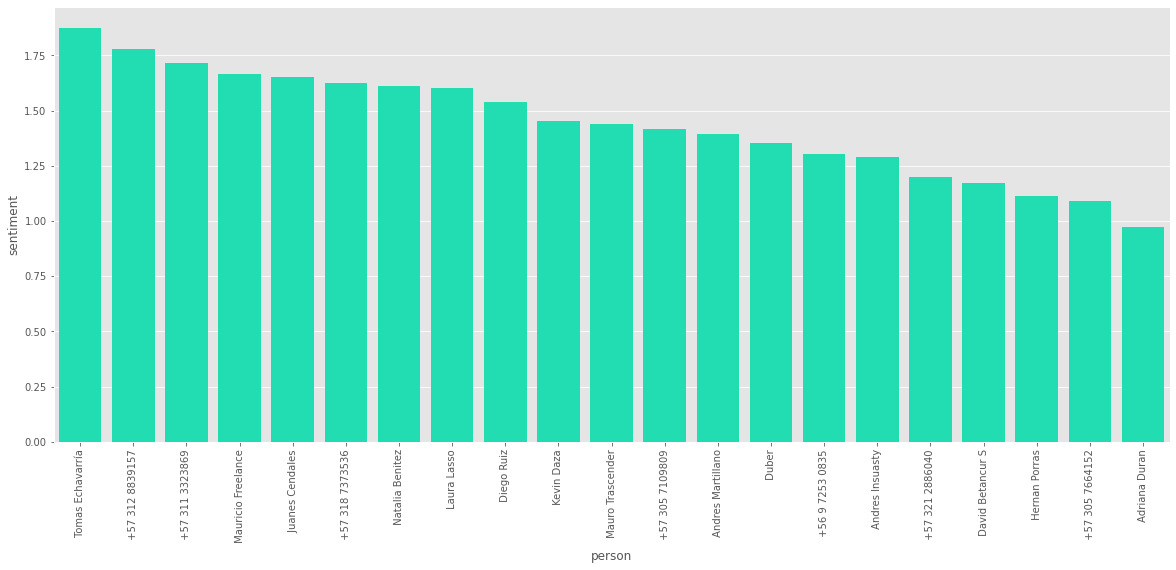

In [23]:
plt.figure(figsize=(20,8))
sns.barplot(x = "person", y = "sentiment", data=mean_df, color="#03fcc2")
plt.xticks(rotation="vertical")
plt.show()